# Frequency Synthesizer with Programmable Sweep

For a better experience, please open in Colab:

<a target="_blank" href="https://colab.research.google.com/drive/1xhQ1qmw5kREtI5oZhr7zMiE3blUzZ5R-?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

```
Submission for IEEE SSCS Open-Source Ecosystem “Code-a-Chip” Travel Grant Awards at VLSI'24
Adithya Sunil Edakkadan, April 2024
SPDX-License-Identifier: Apache-2.0
```

|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|Adithya Sunil Edakkadan <br /> Email ID: adithyasunil26@gmail.com|IIIT, Hyderabad |Yes|No|

<br>
<br>

---

<br>
<br>

With the growth of applications such as quantum sensing which have a wide array of applications in material science, mesoscopic physics and life science, there is an increasing requirement for frequency synthesizers with programmable sweep-step size.

### NV Magnetometry

Considering the example of nitrogen vacancy magnetometry, Nitrogen-Vacancy (NV) centre in diamond behaves as an isolated electronic spin system that can be used in quantum sensors [1]. When a vacancy replaces the adjacent carbon pair in a diamond lattice, the nitrogen atom and the vacancy form an NV centre. The NV defect has its ground level in a spin triplet state whose sub-levels are split in energy into a singlet ($m_s=0$) and a doublet  of degenerate levels ($m_s=\pm1$) separated by 2.87 GHz [2]. When an external magnetic field is applied on the NV ground state spin triplet, a Zeeman shift of energy $\gamma_eB_z$ is induced, where $B_z$ represents the magnetic field component along the NV symmetry axis.

![ODMR](https://drive.google.com/uc?export=view&id=1gAIWnlV9TrA38i8EY8ILpdNn9xnHf7S6)

As shown in figure, optically detected magnetic resonance (ODMR) technique can be used in NV-based sensing to measure static or slow varying $|\vec{B_z}|$ [1], [2]. In ODMR, NV electron spin transitions are excited by a microwave signal ($f_{RF}$) near 2.87 GHz and diamond is irradiated with a green light, which produces a red light proportional to $|\vec{B_z}|$ and having photon frequency $\Delta f_p$, which is detected using a photo-diode [1].

$$\Delta f_p = f_+ - f_- = 2\gamma_e|\vec{B_z}| $$

$\gamma_e$ is gyromagnetic ratio (28 GHz/T) and $f_+$ and $f_-$ are the transition frequencies from the singlet level to the doublet levels.
Usually, NV-ODMR is detected with lock-in technique for which $f_{RF}$ is frequency modulated ($f_m$) while using an external source [1]-[4]. The sensitivity of measured $|\vec{B_z}|$ can be improved with reduced $f_m$, which results into lower $\Delta f_p$. Moreover, overall power can also be reduced by having on-chip frequency sweep than using the external frequency modulator.


### This Work

Towards the goal on minimziing sweep step size and power consumption, in this work, we present - 1) design of a microwave signal generator with a programmable sweep-step size, 2) it's implementation in the open-source SKY130 PDK technology and 3) post-layout simulation results to validate the MWG design.


### Architecture overview

![PLL](https://drive.google.com/uc?export=view&id=162hQaotxAB3fMqotJTYGZN8dV3hQnN3e)


As shown in figure, a phase-locked loop (PLL) based fractional-N frequency synthesizer has been presented in this work, which contains a crystal oscillator (XO) to generate reference signal ($f_{ref}$), phase/frequency detector (PFD), a charge pump (CP), a loop filter (LPF), a voltage controlled oscillator (VCO) and a programmable divider.


# Install Dependancies

This project is designed in the `SKY130` process node. The following tools have been used for designing and simulating the circuits:
1. Ngspice
1. Magic

The following libraries have been used for processing and visualizing data in the notebook:
1. Numpy
1. Pandas
1. Matplotlib
1. Gdstk
1. CairoSVG

Installing SKY130, Magic, Gdstk and CairoSVG through `mamba` package manager

In [ ]:
%%writefile environment.yml
channels:
  - litex-hub
  - conda-forge
dependencies:
  - open_pdks.sky130a
  - magic
  - gdstk
  - cairosvg

Overwriting environment.yml


In [ ]:
import os

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  !python -m pip install condacolab
  import condacolab
  condacolab.install()

!mamba env update -n base -f environment.yml

✨🍰✨ Everything looks OK!
[+] 0.0s
[+] 0.1s
litex-hub/linux-64    ⣾  
litex-hub/noarch      ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  conda-forge/linux-64                                          No change
[+] 0.2s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  
conda-forge/noarch   1%[+] 0.3s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  
conda-forge/noarch  49%[+] 0.4s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  
conda-forge/noarch  72%[+] 0.5s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  
conda-forge/noarch  95%[+] 0.6s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  
conda-forge/noarch 100%conda-forge/noarch                                
[+] 0.7s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  litex-hub/linux-64                                            No change
litex-hub/noarch                                              No change


Looking for: ['open_pdks.sky130a', 'magic', 'gdstk', 'cairosvg']



  Pinned packages:

  - python 3.10.*
  - python_abi 3.10.* *

Insalling Ngspice using `apt-get` package manager

In [ ]:
!sudo apt-get install ngspice

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ngspice is already the newest version (36+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


Importing required libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gdstk
import cairosvg
from IPython.display import Image,clear_output

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  import condacolab
  CONDA_PREFIX = condacolab.PREFIX

Cloning the repository containing the custom layouts

In [ ]:
!rm -rf sim gds images 2.87GHz-MWG-SKY130
!mkdir sim gds images
!git clone https://github.com/adithyasunil26/2.87GHz-MWG-SKY130.git

Cloning into '2.87GHz-MWG-SKY130'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 134 (delta 53), reused 106 (delta 30), pack-reused 0
Receiving objects: 100% (134/134), 1.60 MiB | 5.65 MiB/s, done.
Resolving deltas: 100% (53/53), done.


## Functions for reading and plotting output data from simulations

These functions allow for reading data exporting from ngspice and plotting them.

In [ ]:
def read_op_file(filename, columns):
  with open(filename, "r") as f:
    op = f.read().split('\n')
  op_filt = []

  for i in op[2:-1]:
    # print(i)
    if i[0] not in ['-','\x0c','I']:
      op_filt.append(i.split('\t')[:-1])
  return pd.DataFrame(op_filt,columns=['s','t']+columns)

def plot_from_op(df):
  for i in df.columns[2:]:
    j = [abs(float(k)) for k in df[i]]
    plt.plot(j, label=i)
  plt.legend()
  plt.ylabel("Voltage (V)")
  plt.show()
  return

## Function for adding signal generation, simulation and control statements to generated `spice` netlists

This function allows for generation of spice netlists for simulation by adding the given signals, simulation commands and control commands to the extracted netlist from magic.

In [ ]:
def mod_extracted_net(path, signals, sim, control):

  with open(path, "r") as f:
    op = f.read()

  signals = signals+'\n'
  sim = sim+'\n'
  control = control+'\n'

  dec = f"""* Simulation

.lib "{CONDA_PREFIX}/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice" tt

.param SUPPLY = 1.8
.global vdd gnd

Vdd vdd gnd 'SUPPLY'
{signals}
"""

  commands = f"""
*Simulation Command
{sim}

* ngspice control statements
.control
run

{control}

.endc
.end
"""

  op = '\n'.join(op.split('\n')[2:-3]).split('.subckt')

  with open(path.split('.')[0]+'_sim.spice', "w") as f:
    f.write(dec+'\n'+'.subckt'.join(op[:-1])+'\n'.join(op[-1].split('\n')[1:])+'\n'+commands)

  return

## Function for reading `meas` outputs from ngspice log

This function is used for reading the output of the `meas` command from the ngspice simulation output.

In [ ]:
def read_meas_from_spice_out(path):
  with open(path, "r") as f:
    op = f.read()
  op = op.split('Measurements for Transient Analysis')[1].split('\n')
  op = [i for i in op if i!=''][:-1]
  meas_out = []
  for i in op:
    meas_out.append(i.split('=')[1].split(' ')[-2])
  return meas_out

# Sample Inverter simulation

In order to test the idea of running `spice` netlists through the notebook and parsing and plotting the outputs, a simple inverter netlist has been created and simulated.

Creating spice netlist for a an inverter circuit

In [ ]:
%%writefile sim/inv.spice
* Transient simulation

.lib "/usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice" tt

.param SUPPLY = 1.8
.global vdd gnd

Vdd vdd gnd 'SUPPLY'
va a gnd pulse 1.8 0 0ns 10ps 10ps 10ns 20ns

X1 out a gnd gnd sky130_fd_pr__nfet_01v8 ad=0p pd=0u as=0p ps=0u w=900000u l=150000u
X2 out a vdd vdd sky130_fd_pr__pfet_01v8 ad=0p pd=0u as=0p ps=0u w=1.8e+06u l=150000u

*Simulation Command
.tran 1ns 50ns

* ngspice control statements
.control

run
print v(a) v(out) > inv_plot_data.txt
quit

.endc

.end


Writing sim/inv.spice


Simulating created netlist using ngspice and plotting the input and output signals of the inverter

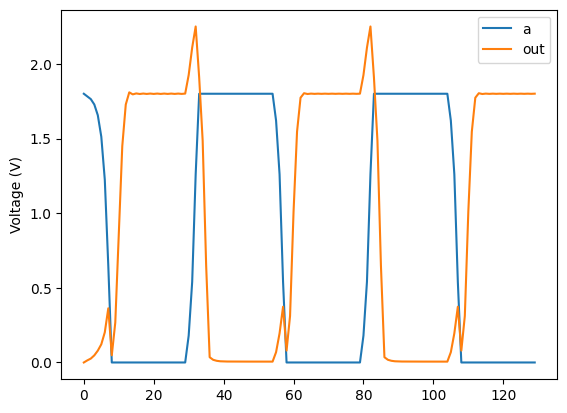

In [ ]:
!cd sim/ && ngspice inv.spice
clear_output(wait=False)  # Keeps notebook tidy by clearing ngspice terminal outputs

a_vs_out = read_op_file("sim/inv_plot_data.txt", ["a","out"])
plot_from_op(a_vs_out)

# Loading and simulating custom magic layouts for analog circuits

Since this work makes use of analog and RF blocks, the layouts have been done manually using `magic`. These `.mag` files need to be imported and the respective `.spice` netlists extracted for simulation and `.gds` files generated.

Loading custom inverter layout in magic to extract spice netlist and generate GDSII file

In [ ]:
%%script magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc

load 2.87GHz-MWG-SKY130/mag/pd/inverter.mag

extract
ext2spice lvs
ext2spice cthresh 0
ext2spice

gds labels no
gds write gds/inverter.gds


Magic 8.3 revision 464 - Compiled on Sat Mar  9 23:18:29 UTC 2024.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.471-0-g97d0844
Cell inverter read from path 2.87GHz-MWG-SKY130/mag/pd
Scaled magic input cell inverter geometry by factor of 2
Extracting inverter into 2.87GHz-MWG-SKY130/mag/pd/inverter.ext:
exttospice finished.
   Generating output for cell inverter


Viewing the generated GDSII file

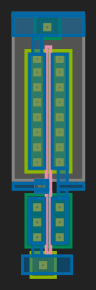

In [ ]:
library = gdstk.read_gds('gds/inverter.gds')
top_cells = library.top_level()
top_cells[0].write_svg('images/inverter.svg')
cairosvg.svg2png(url='images/inverter.svg', write_to='images/inverter.png', scale=3.0)
Image('images/inverter.png')

Simulating extracted netlists in ngspice and plotting waveforms

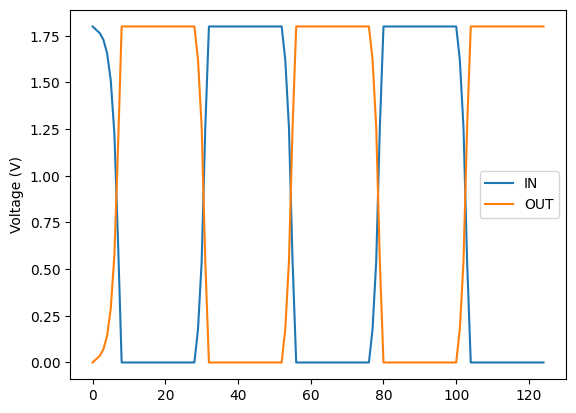

In [ ]:
!mv *.spice sim/

path = "sim/inverter.spice"
signals = "va IN gnd pulse 1.8 0 0ns 10ps 10ps 10ns 20ns"
sim = ".tran 1ns 50ns"
control = "print v(IN) v(OUT) > inv_plot_data.txt"
control = control+"\nquit"
mod_extracted_net(path, signals, sim, control)

!cd sim/ && ngspice inverter_sim.spice
clear_output(wait=False)

plot_from_op(read_op_file("sim/inv_plot_data.txt", ["IN","OUT"]))

# Design and simulation of individual blocks

The frequency synthesizer is divided into the following blocks:
1. Voltage controlled oscillator
1. Multi-modulus programmable divider
1. Phase-frequency detector
1. Charge Pump and loop filter

Each block is designed and simulated individually using `magic` and `ngspice`.

## Voltage Controlled Oscillator (VCO)

### Low Gain VCO Design Consideration

For low frequency resolution with low phase noise while providing a sufficiently wide tuning range, the gain of the VCO ($K_{VCO}$) can be estimated by

  $$ \Delta f = K_{VCO}\times\Delta V_{cont}$$

where, $\Delta V_{cont}$ is the change in control voltage at VCO input.
Very small values (few 100's $\mu$V) of $\Delta V_{cont}$ are more prone to noise, whereas larger values (10's of mV) will require extremely low $K_{VCO}$. To achieve this low $K_{VCO}$ requirement, there are two choices for the VCO realization - 1) LC VCO or 2) ring VCO with CMOS inverters. LC VCO choice results in increased chip area and possibility of degradation of field homogeneity in the sensing area due to the magnetic coupling between on-chip inductor and $|\vec{B_z}|$ [1]. Therefore, an M-stage ring oscillator (RO) topology is chosen in the proposed work, for which, oscillation frequency ($f_{RF}$) can be given by

$$f_{RF} = \frac{1}{2Mt_d}$$

$t_d$ ($\propto C_{T}$) is the delay of each stage, where $C_{T}$ is the total capacitance at each node. Gain of the ring VCO can be expressed by

$$|K_{VCO}| = \frac{\partial f_{RF}}{\partial V_{cont}} = \frac{1}{2Mt_d^2} \frac{\partial t_d}{\partial V_{cont}} = 2Mf_{RF}^2\frac{\partial t_d}{\partial V_{cont}} $$

This gives important insights about designing low gain ring $VCO$ - 1) by minimizing M and 2) by making $C_T$ a weaker function of $V_{cont}$ to reduce $\frac{\partial t_d}{\partial V_{cont}}$.

### Implementation

![VCO](https://drive.google.com/uc?export=view&id=1Gd3sH0xImRpE8xA1sh6tsxq4HIq98lIl)

The proposed VCO uses the minimum number (M=3) of CMOS inverter stages with  varactor and a capacitor bank at each node. As shown in the figure, each capacitor bank contains a fix capacitance ($C_{fix}$) and parallel combination of 6 unit capacitance ($C_u$), which are realized using MIM capacitors. $C_u$ is used
for the coarse tuning of the VCO and is controlled by a 6-bit signal ($A_5...A_0$).
MOS varactors are controlled by $V_{cont}$ and facilitate the finer tuning of $f_{RF}$ [6]. Varactors with minimum size have been used for having the least value of $\frac{\partial t_d}{\partial V_{cont}}$ for low $K_{VCO}$.

### Generating gds and `spice` netlists from `.mag` for VCO

In [ ]:
%%script magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc

load 2.87GHz-MWG-SKY130/mag/ro/ro_complete.mag

extract
ext2spice lvs
ext2spice cthresh 0
ext2spice

gds labels no
gds write gds/ro_complete.gds


Magic 8.3 revision 464 - Compiled on Sat Mar  9 23:18:29 UTC 2024.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.471-0-g97d0844
Cell ro_complete read from path 2.87GHz-MWG-SKY130/mag/ro
Scaled magic input cell ro_complete geometry by factor of 2
Cell ro_var_extend read from path 2.87GHz-MWG-SKY130/mag/ro
Cell cbank read from path 2.87GHz-MWG-SKY130/mag/ro
Cell switch read from path 2.87GHz-MWG-SKY130/mag/ro
Scaled magic input cell switch geometry by factor of 2
Processing timestamp mismatches.
Timestamp mismatches found in the

In [ ]:
%%script magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc

load 2.87GHz-MWG-SKY130/mag/ro/ro_var_extend.mag

extract
ext2spice lvs
ext2spice cthresh 0
ext2spice

gds labels no
gds write gds/ro_var_extend.gds


Magic 8.3 revision 464 - Compiled on Sat Mar  9 23:18:29 UTC 2024.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.471-0-g97d0844
Cell ro_var_extend read from path 2.87GHz-MWG-SKY130/mag/ro
Extracting ro_var_extend into 2.87GHz-MWG-SKY130/mag/ro/ro_var_extend.ext:
exttospice finished.
   Generating output for cell ro_var_extend


In [ ]:
%%script magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc

load 2.87GHz-MWG-SKY130/mag/ro/ro_with_cbank.mag

extract
ext2spice lvs
ext2spice cthresh 0
ext2spice

gds labels no
gds write gds/ro_with_cbank.gds


Magic 8.3 revision 464 - Compiled on Sat Mar  9 23:18:29 UTC 2024.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.471-0-g97d0844
Cell ro_with_cbank read from path 2.87GHz-MWG-SKY130/mag/ro
Scaled magic input cell ro_with_cbank geometry by factor of 2
Cell cbank_smol read from path 2.87GHz-MWG-SKY130/mag/ro
Cell switch read from path 2.87GHz-MWG-SKY130/mag/ro
Scaled magic input cell switch geometry by factor of 2
Cell ro_var_extend read from path 2.87GHz-MWG-SKY130/mag/ro
Extracting switch into 2.87GHz-MWG-SKY130/mag/ro/switch.e

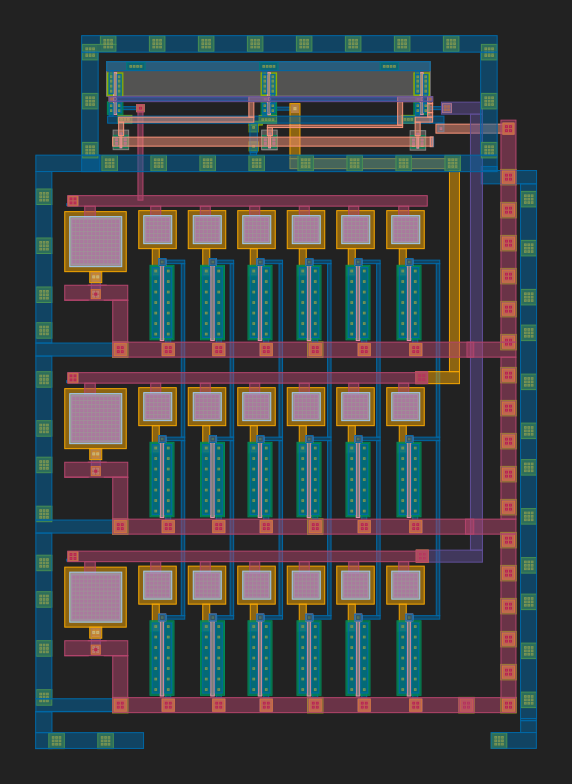

In [ ]:
library = gdstk.read_gds('gds/ro_complete.gds')
top_cells = library.top_level()
top_cells[0].write_svg('images/ro_complete.svg')
cairosvg.svg2png(url='images/ro_complete.svg', write_to='images/ro_complete.png', scale=1.0)
Image('images/ro_complete.png')

### Simulating VCO

The ring oscillator present in the VCO is simulated. The frequency at each stage of the 3 stage RO is obtained.

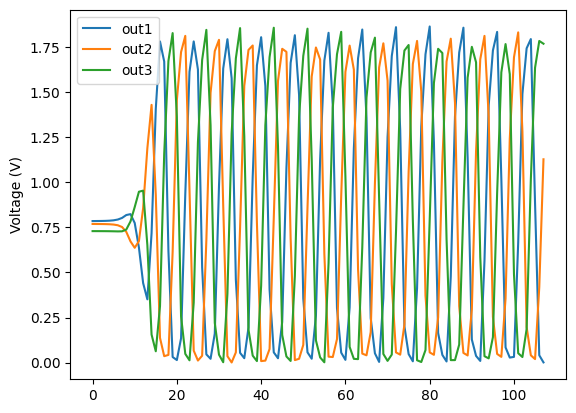

Frequency of out1 = 1.2583545303153965 GHz
Frequency of out2 = 1.261163026887113 GHz
Frequency of out3 = 1.2586551420845444 GHz


In [ ]:
!mv *.spice sim/

path = "sim/ro_var_extend.spice"
signals = "vcont vcont gnd dc 1.8"
sim = """.tran 0.1ns 10ns
.measure tran out1 TRIG v(out1) VAL=0.9  RISE=5  TARG v(out1) VAL=0.9  RISE=6
.measure tran out2 TRIG v(out2) VAL=0.9  RISE=5  TARG v(out2) VAL=0.9  RISE=6
.measure tran out3 TRIG v(out3) VAL=0.9  RISE=5  TARG v(out3) VAL=0.9  RISE=6"""
control = """print v(out1) v(out2) v(out3) > ro_data.txt
quit"""
mod_extracted_net(path, signals, sim, control)

!cd sim/ && ngspice ro_var_extend_sim.spice > ro_out.txt
clear_output(wait=False)

plot_from_op(read_op_file("sim/ro_data.txt", ["out1","out2","out3"]))

meas = read_meas_from_spice_out('sim/ro_out.txt')
print("Frequency of out1 = "+ str(1e-9*1/float(meas[0])) +" GHz")
print("Frequency of out2 = "+ str(1e-9*1/float(meas[1])) +" GHz")
print("Frequency of out3 = "+ str(1e-9*1/float(meas[2])) +" GHz")

The variation of output frequency with change in VCO control voltage is observed by sweeping control voltage from 0V to 1.9V in steps of 0.1V.

> Note: The following cell may take quite some time to run

Text(0.5, 0, 'Control Voltage (V)')

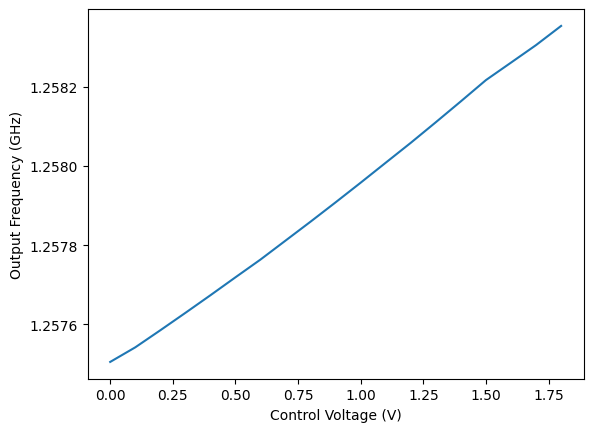

In [ ]:
out_v = []
for i in np.arange(0,1.9,0.1):
  path = "sim/ro_var_extend.spice"
  signals = "vcont vcont gnd dc "+str(i)
  sim = """.tran 0.1ns 10ns
  .measure tran out1 TRIG v(out1) VAL=0.9  RISE=5  TARG v(out1) VAL=0.9  RISE=6
  .measure tran out2 TRIG v(out2) VAL=0.9  RISE=5  TARG v(out2) VAL=0.9  RISE=6
  .measure tran out3 TRIG v(out3) VAL=0.9  RISE=5  TARG v(out3) VAL=0.9  RISE=6"""
  control = """print v(out1) v(out2) v(out3) > ro_data.txt
  quit"""
  mod_extracted_net(path, signals, sim, control)

  !cd sim/ && ngspice ro_var_extend_sim.spice > ro_out.txt
  clear_output(wait=False)

  meas = read_meas_from_spice_out('sim/ro_out.txt')
  out_v.append(1e-9*1/float(meas[0]))

plt.plot(np.arange(0,1.9,0.1),out_v)
plt.ylabel("Output Frequency (GHz)")
plt.xlabel("Control Voltage (V)")

It is noted that the control voltage can be used only for fine tuning of the output frequency. The capacitor bank is added for the coarse tuning of output frequency.

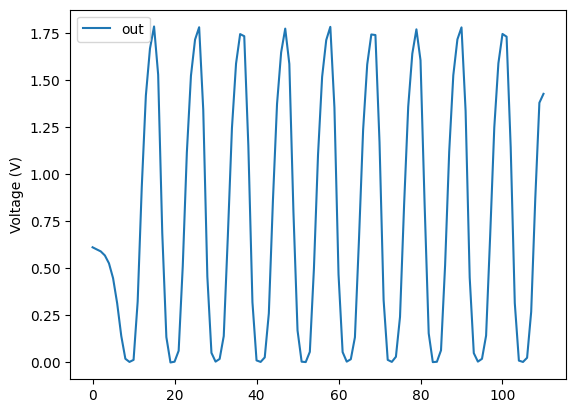

Frequency of out = 0.9587801248715235 GHz


In [ ]:
!mv *.spice sim/

path = "sim/ro_with_cbank.spice"
signals = """vcont vcont gnd dc 1.8
va0 a0 gnd dc 0
va1 a1 gnd dc 0
va2 a2 gnd dc 0
va3 a3 gnd dc 0
va4 a4 gnd dc 0
va5 a5 gnd dc 0"""
sim = """.tran 0.1ns 10ns
.measure tran out TRIG v(out) VAL=0.9  RISE=5  TARG v(out) VAL=0.9  RISE=6"""
control = """print v(out) > ro_with_cbank_data.txt
quit"""
mod_extracted_net(path, signals, sim, control)

!cd sim/ && ngspice ro_with_cbank_sim.spice > ro_with_cbank_out.txt

clear_output(wait=False)

plot_from_op(read_op_file("sim/ro_with_cbank_data.txt", ["out"]))

meas = read_meas_from_spice_out('sim/ro_with_cbank_out.txt')
print("Frequency of out = "+ str(1e-9*1/float(meas[0])) +" GHz")

The functioning of the capacitor bank and change in frequency with capacitor bank steps can be observed using the following cell of code.

> Note: The following cell may take quite some time to run

In [ ]:
!mv *.spice sim/

out_v = []
path = "sim/ro_with_cbank.spice"
sim = """.tran 0.1ns 30ns
.measure tran out TRIG v(out) VAL=0.9  RISE=5  TARG v(out) VAL=0.9  RISE=6"""

signals = """vcont vcont gnd dc 1.8
va0 a0 gnd dc 0
va1 a1 gnd dc 0
va2 a2 gnd dc 0
va3 a3 gnd dc 0
va4 a4 gnd dc 0
va5 a5 gnd dc 0"""
control = """print v(out) > ro_with_cbank_data.txt
quit"""
mod_extracted_net(path, signals, sim, control)
!cd sim/ && ngspice ro_with_cbank_sim.spice > ro_with_cbank_out.txt
clear_output(wait=False)
out_v.append(1e-6*1/float(read_meas_from_spice_out('sim/ro_with_cbank_out.txt')[0]))

signals = """vcont vcont gnd dc 1.8
va0 a0 gnd dc 1.8
va1 a1 gnd dc 0
va2 a2 gnd dc 0
va3 a3 gnd dc 0
va4 a4 gnd dc 0
va5 a5 gnd dc 0"""
control = """print v(out) > ro_with_cbank_data.txt
quit"""
mod_extracted_net(path, signals, sim, control)
!cd sim/ && ngspice ro_with_cbank_sim.spice > ro_with_cbank_out.txt
clear_output(wait=False)
out_v.append(1e-6*1/float(read_meas_from_spice_out('sim/ro_with_cbank_out.txt')[0]))

signals = """vcont vcont gnd dc 1.8
va0 a0 gnd dc 1.8
va1 a1 gnd dc 1.8
va2 a2 gnd dc 0
va3 a3 gnd dc 0
va4 a4 gnd dc 0
va5 a5 gnd dc 0"""
control = """print v(out) > ro_with_cbank_data.txt
quit"""
mod_extracted_net(path, signals, sim, control)
!cd sim/ && ngspice ro_with_cbank_sim.spice > ro_with_cbank_out.txt
clear_output(wait=False)
out_v.append(1e-6*1/float(read_meas_from_spice_out('sim/ro_with_cbank_out.txt')[0]))

signals = """vcont vcont gnd dc 1.8
va0 a0 gnd dc 1.8
va1 a1 gnd dc 1.8
va2 a2 gnd dc 1.8
va3 a3 gnd dc 0
va4 a4 gnd dc 0
va5 a5 gnd dc 0"""
control = """print v(out) > ro_with_cbank_data.txt
quit"""
mod_extracted_net(path, signals, sim, control)
!cd sim/ && ngspice ro_with_cbank_sim.spice > ro_with_cbank_out.txt
clear_output(wait=False)
out_v.append(1e-6*1/float(read_meas_from_spice_out('sim/ro_with_cbank_out.txt')[0]))

signals = """vcont vcont gnd dc 1.8
va0 a0 gnd dc 1.8
va1 a1 gnd dc 1.8
va2 a2 gnd dc 1.8
va3 a3 gnd dc 1.8
va4 a4 gnd dc 0
va5 a5 gnd dc 0"""
control = """print v(out) > ro_with_cbank_data.txt
quit"""
mod_extracted_net(path, signals, sim, control)
!cd sim/ && ngspice ro_with_cbank_sim.spice > ro_with_cbank_out.txt
clear_output(wait=False)
out_v.append(1e-6*1/float(read_meas_from_spice_out('sim/ro_with_cbank_out.txt')[0]))

signals = """vcont vcont gnd dc 1.8
va0 a0 gnd dc 1.8
va1 a1 gnd dc 1.8
va2 a2 gnd dc 1.8
va3 a3 gnd dc 1.8
va4 a4 gnd dc 1.8
va5 a5 gnd dc 0"""
control = """print v(out) > ro_with_cbank_data.txt
quit"""
mod_extracted_net(path, signals, sim, control)
!cd sim/ && ngspice ro_with_cbank_sim.spice > ro_with_cbank_out.txt
clear_output(wait=False)
out_v.append(1e-6*1/float(read_meas_from_spice_out('sim/ro_with_cbank_out.txt')[0]))

signals = """vcont vcont gnd dc 1.8
va0 a0 gnd dc 1.8
va1 a1 gnd dc 1.8
va2 a2 gnd dc 1.8
va3 a3 gnd dc 1.8
va4 a4 gnd dc 1.8
va5 a5 gnd dc 1.8"""
control = """print v(out) > ro_with_cbank_data.txt
quit"""
mod_extracted_net(path, signals, sim, control)
!cd sim/ && ngspice ro_with_cbank_sim.spice > ro_with_cbank_out.txt
clear_output(wait=False)
out_v.append(1e-6*1/float(read_meas_from_spice_out('sim/ro_with_cbank_out.txt')[0]))

plt.plot(out_v)
plt.xlabel("Capacitance Bank Steps")
plt.ylabel("Frequency(MHz)")
plt.show()

## Multi-modulus divider

### Programmable Divider Design Considerations

In order to obtain a resolution of  $\Delta f$ near $f_{RF}$, the divider must divide by $(N+1)$ for a fraction $x$ of the cycles of reference signal having frequency $f_{ref}$ and divide by $N$ for the remaining cycles [10].

$$f_{RF} + \Delta f = (N+x) f_{ref}$$

Under locked condition ($f_{RF} = N \times f_{ref}$), $x = \frac{\Delta f}{f_{ref}}$. A modulus control signal is generated by considering $x=\frac{p}{q}$, where $p$ and $q$ are the number of total reference cycles and number cycles for which the modulus signal is low, respectively. This modulus control signal programs the divider for fractional-N operation and switches the center frequency of the VCO. Very low $f_{ref}$ will require high N resulting into more area and dynamic power consumption, whereas very high $f_{ref}$ will make $x$ too small, which will require more number of reference cycles for fractional-N operation.  Considering these points, we chose $f_{ref}\approx$ 90 MHz, which gives N=32.

### Implementation


![Multi-modulus divider](https://drive.google.com/uc?export=view&id=1xrlQR3XcrxOOtkNAKHK5cZZ9If6BgJtm)


The programmable divider of the proposed MWG consists of three True Single-Phase Clock (TSPC) D flip-flops and a 4/5 prescaler that clocks the TSPC stages controlled by $MC_1$ which is NOR of the input of each of the TSPC stages and the modulus control signal [7].

![Prescaler](https://drive.google.com/uc?export=view&id=1WQpKvqkDDDbqb2GJydOMmIQjvgwB_sdr)

The 4/5 prescaler consists of TSPC stages and the required NAND logic to switch between divide by 4 and 5 based on $MC_1$.

![TSPC](https://drive.google.com/uc?export=view&id=1VUmbZrFnYLIibeJ4Nbo61SBG3cbPstTP)

Figure shows the schematic of the TSPC logic based D flip flops [8]. Each TSPC stage acts as divide by 2 unit.

### Generating gds and `spice` netlists from `.mag` for multi-modulus divider

In [ ]:
%%script magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc

load 2.87GHz-MWG-SKY130/mag/div/divider.mag

extract
ext2spice lvs
ext2spice cthresh 0
ext2spice

gds labels no
gds write gds/divider.gds


Magic 8.3 revision 464 - Compiled on Sat Mar  9 23:18:29 UTC 2024.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.471-0-g97d0844
Cell divider read from path 2.87GHz-MWG-SKY130/mag/div
Scaled magic input cell divider geometry by factor of 2
Cell tspc read from path 2.87GHz-MWG-SKY130/mag/div
Scaled magic input cell tspc geometry by factor of 2
Cell and read from path 2.87GHz-MWG-SKY130/mag/div
Scaled magic input cell and geometry by factor of 2
Cell nor read from path 2.87GHz-MWG-SKY130/mag/div
Scaled magic input cell nor geomet

freeMagic called with NULL argument.
Total of 14 warnings.


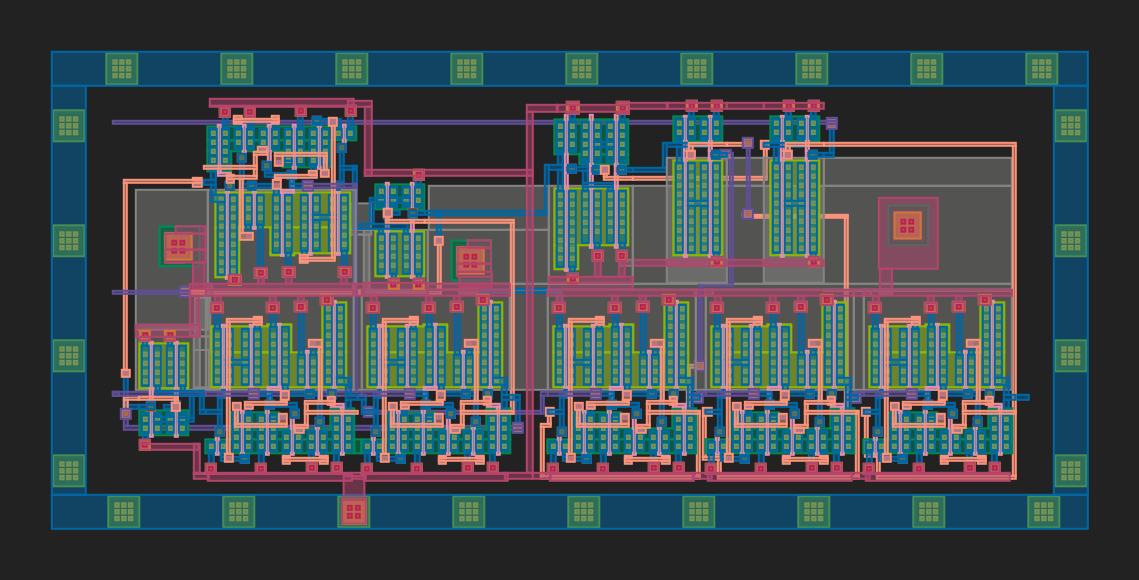

In [ ]:
library = gdstk.read_gds('gds/divider.gds')
top_cells = library.top_level()
top_cells[0].write_svg('images/divider.svg')
cairosvg.svg2png(url='images/divider.svg', write_to='images/divider.png', scale=2.0)
Image('images/divider.png')

### Simulating multi-modulus divider

The multi-modulus divider needs to be tested to ensure that it is able to produce the 2 different divide ratios controlled by the modulus control signal. An input signal is 1.25 GHz frequency is considered.

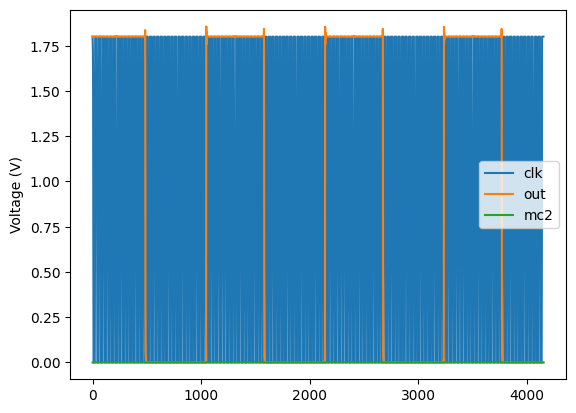

Divider simulation with MC2 signal at `LOW`
Frequency of out = 37.878787878787875 MHz


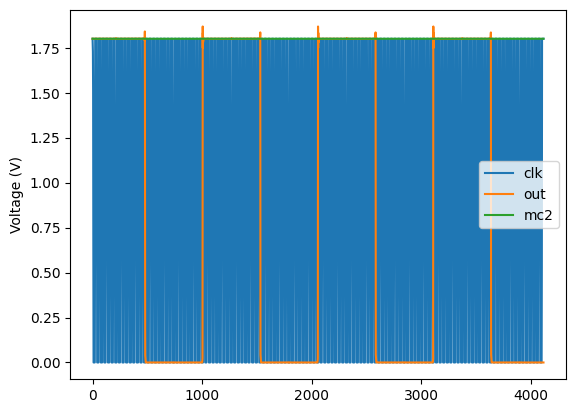

Divider simulation with MC2 signal at `HIGH`
Frequency of out = 39.0625 MHz


In [ ]:
!mv *.spice sim/


path = "sim/divider.spice"
signals = """vmc mc2 gnd dc 0
vclk clk gnd pulse 1.8 0 0ns 10ps 10ps 0.4ns 0.8ns"""
sim = """.tran 0.1ns 100ns
.measure tran out TRIG v(out) VAL=0.9  RISE=2  TARG v(out) VAL=0.9  RISE=3"""
control = "print v(clk) v(out) v(mc2)> div_data_1.txt"
control = control+"\nquit"
mod_extracted_net(path, signals, sim, control)

!cd sim/ && ngspice divider_sim.spice > div_out_1.txt
clear_output(wait=False)

path = "sim/divider.spice"
signals = """vmc mc2 gnd dc 1.8
vclk clk gnd pulse 1.8 0 0ns 10ps 10ps 0.4ns 0.8ns"""
sim = """.tran 0.1ns 100ns
.measure tran out TRIG v(out) VAL=0.9  RISE=2  TARG v(out) VAL=0.9  RISE=3"""
control = "print v(clk) v(out) v(mc2)> div_data_2.txt"
control = control+"\nquit"
mod_extracted_net(path, signals, sim, control)

!cd sim/ && ngspice divider_sim.spice > div_out_2.txt
clear_output(wait=False)

plot_from_op(read_op_file("sim/div_data_1.txt", ["clk","out","mc2"]))
meas = read_meas_from_spice_out('sim/div_out_1.txt')
print("Divider simulation with MC2 signal at `LOW`")
print("Frequency of out = "+ str(1e-6*1/float(meas[0])) +" MHz")

plot_from_op(read_op_file("sim/div_data_2.txt", ["clk","out","mc2"]))
meas = read_meas_from_spice_out('sim/div_out_2.txt')
print("Divider simulation with MC2 signal at `HIGH`")
print("Frequency of out = "+ str(1e-6*1/float(meas[0])) +" MHz")

The output frequencies produced by the divider for the different values of the modulus control signal are 37.8787 MHz (1.25 GHz divided by 33) and 39.0625 MHz (1.25 GHz divided by 32).

## Phase-Frequency Detector (PFD)

![PFD](https://drive.google.com/uc?export=view&id=1IU0h2xTBJ0mjZKY4iRR20bvuBcZ9i9FJ)

Figure shows the block diagram of the PFD, which consists of two D-flip-flops and an AND gate [9]. The two flip-flops have their inputs connected to supply and clocked by the reference signal ($f_{ref}$) and divider output (Div),  respectively. They generate the Up and Down pulses for driving the charge pump (CP) according to the phase difference in the reference and divider output signals [10].

### Generating gds and `spice` netlists from `.mag` for PFD

In [ ]:
%%script magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc

load 2.87GHz-MWG-SKY130/mag/pd/pd.mag

extract
ext2spice lvs
ext2spice cthresh 0
ext2spice

gds labels no
gds write gds/pd.gds


Magic 8.3 revision 464 - Compiled on Sat Mar  9 23:18:29 UTC 2024.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.471-0-g97d0844
Cell pd read from path 2.87GHz-MWG-SKY130/mag/pd
Scaled magic input cell pd geometry by factor of 2
Cell tspc_r read from path 2.87GHz-MWG-SKY130/mag/pd
Scaled magic input cell tspc_r geometry by factor of 2
Cell and_pd read from path 2.87GHz-MWG-SKY130/mag/pd
Scaled magic input cell and_pd geometry by factor of 2
Processing timestamp mismatches.
Timestamp mismatches found in these cells: tspc_r, and_

freeMagic called with NULL argument.
Total of 3 warnings.


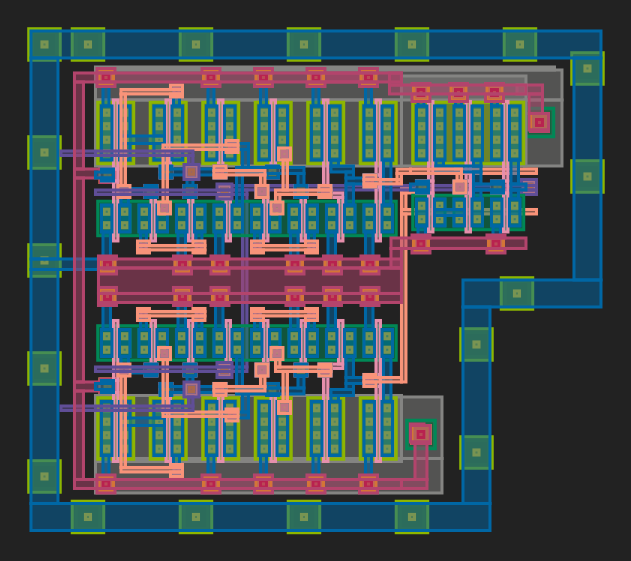

In [ ]:
library = gdstk.read_gds('gds/pd.gds')
top_cells = library.top_level()
top_cells[0].write_svg('images/pd.svg')
cairosvg.svg2png(url='images/pd.svg', write_to='images/pd.png', scale=3.0)
Image('images/pd.png')

### Simulating pulse frequency detector

The 4 possible cases are
1. Divider output leads reference signal with higher frequency
1. Divider output leads reference signal with lower frequency
1. Divider output follows reference signal with higher frequency
1. Divider output follows reference signal with lower frequency
All cases are simlated using the following cell.

> Note: The following cell may take quite some time to run

Divider output leading reference signal with higher frequency


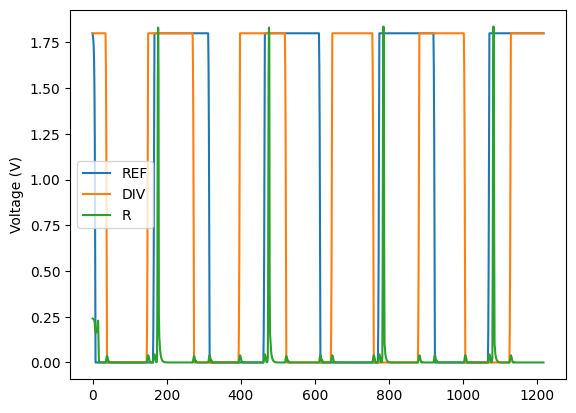

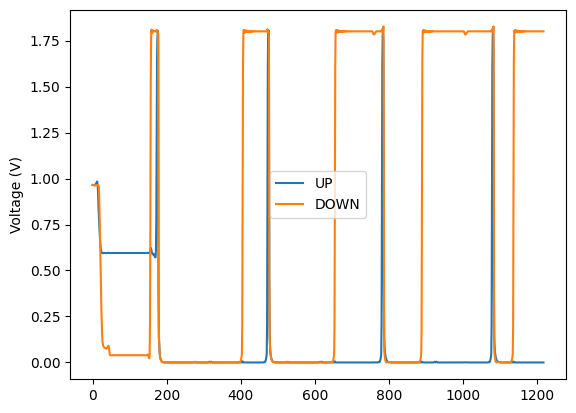

Divider output leading reference signal with lower frequency


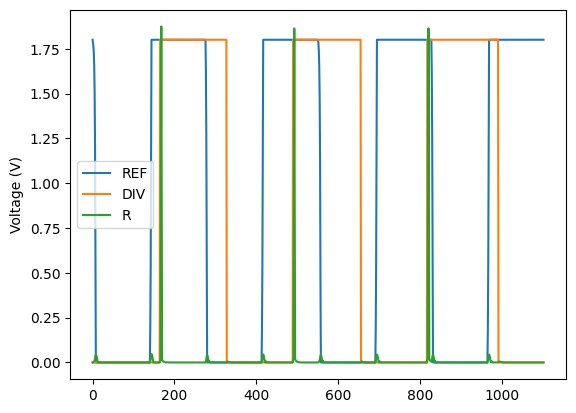

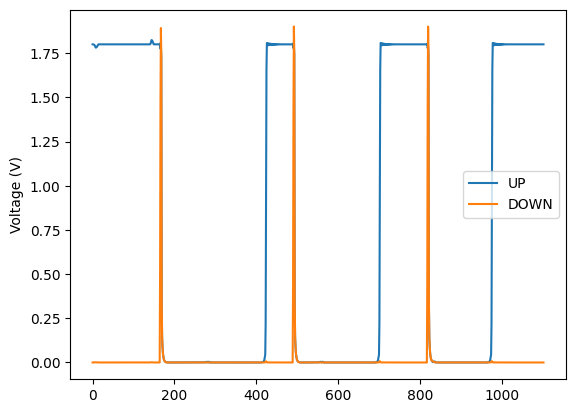

Divider output following reference signal with higher frequency


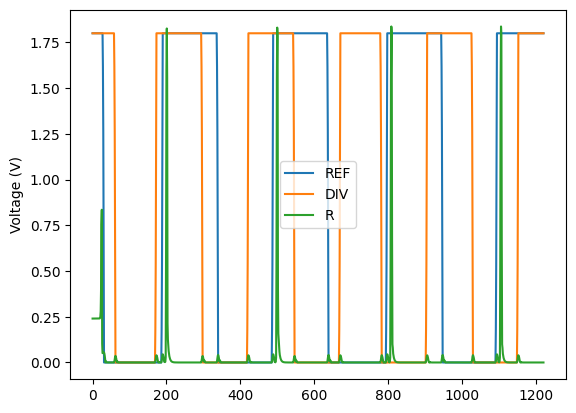

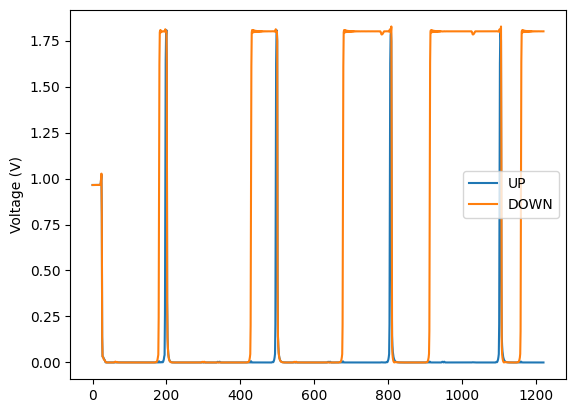

Divider output following reference signal with lower frequency


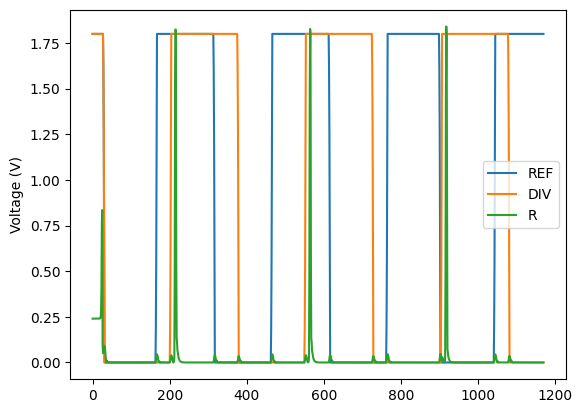

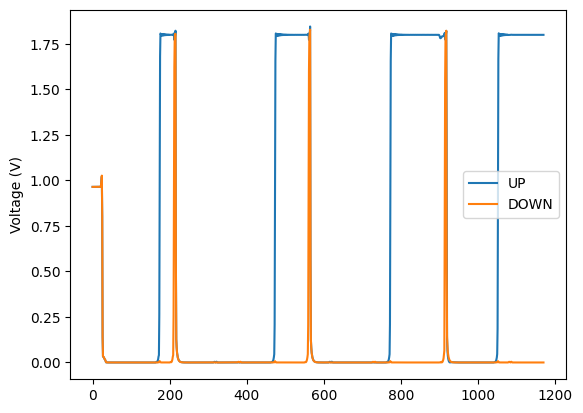

In [ ]:
!mv *.spice sim/


path = "sim/pd.spice"
signals = """vref REF gnd pulse 1.8 0 0ns 10ps 10ps 12.5ns 25ns
vdiv DIV gnd pulse 1.8 0 2ns 10ps 10ps 10ns 20ns
"""
sim = ".tran 0.1ns 100ns"
control = """print v(REF) v(DIV) v(R)> pd_data_1_1.txt
print v(UP) v(DOWN)> pd_data_1_2.txt
quit"""
mod_extracted_net(path, signals, sim, control)
!cd sim/ && ngspice pd_sim.spice > pd_out_1.txt

path = "sim/pd.spice"
signals = """vref REF gnd pulse 1.8 0 0ns 10ps 10ps 12.5ns 25ns
vdiv DIV gnd pulse 1.8 0 -1ns 10ps 10ps 15ns 30ns
"""
sim = ".tran 0.1ns 100ns"
control = """print v(REF) v(DIV) v(R)> pd_data_2_1.txt
print v(UP) v(DOWN)> pd_data_2_2.txt
quit"""
mod_extracted_net(path, signals, sim, control)
!cd sim/ && ngspice pd_sim.spice > pd_out_1.txt

path = "sim/pd.spice"
signals = """vref REF gnd pulse 1.8 0 2ns 10ps 10ps 12.5ns 25ns
vdiv DIV gnd pulse 1.8 0 4ns 10ps 10ps 10ns 20ns
"""
sim = ".tran 0.1ns 100ns"
control = """print v(REF) v(DIV) v(R)> pd_data_3_1.txt
print v(UP) v(DOWN)> pd_data_3_2.txt
quit"""
mod_extracted_net(path, signals, sim, control)
!cd sim/ && ngspice pd_sim.spice > pd_out_2.txt

path = "sim/pd.spice"
signals = """vref REF gnd pulse 1.8 0 2ns 10ps 10ps 12.5ns 25ns
vdiv DIV gnd pulse 1.8 0 2ns 10ps 10ps 15ns 30ns
"""
sim = ".tran 0.1ns 100ns"
control = """print v(REF) v(DIV) v(R)> pd_data_4_1.txt
print v(UP) v(DOWN)> pd_data_4_2.txt
quit"""
mod_extracted_net(path, signals, sim, control)
!cd sim/ && ngspice pd_sim.spice > pd_out_2.txt

clear_output(wait=False)

print("Divider output leading reference signal with higher frequency")
plot_from_op(read_op_file("sim/pd_data_1_1.txt", ["REF","DIV","R"]))
plot_from_op(read_op_file("sim/pd_data_1_2.txt", ["UP","DOWN"]))
print("Divider output leading reference signal with lower frequency")
plot_from_op(read_op_file("sim/pd_data_2_1.txt", ["REF","DIV","R"]))
plot_from_op(read_op_file("sim/pd_data_2_2.txt", ["UP","DOWN"]))
print("Divider output following reference signal with higher frequency")
plot_from_op(read_op_file("sim/pd_data_3_1.txt", ["REF","DIV","R"]))
plot_from_op(read_op_file("sim/pd_data_3_2.txt", ["UP","DOWN"]))
print("Divider output following reference signal with lower frequency")
plot_from_op(read_op_file("sim/pd_data_4_1.txt", ["REF","DIV","R"]))
plot_from_op(read_op_file("sim/pd_data_4_2.txt", ["UP","DOWN"]))

## Charge Pump (CP) and loop filter (LF)

![CP](https://drive.google.com/uc?export=view&id=1bFTvIZfI4V_lGdcsznFBsUZkG210Lu_K)

Figure shows the topology used to realize CP based on the dynamic current-matching technique, which minimizes current mismatches by using additional feedback transistors that compensate for the channel length modulation [11]. As shown in figure, the loop filter comprised of $R_1$, $C_1$ and $C_2$ [9].

### Generating gds and `spice` netlists from `.mag` for CPLF


In [ ]:
%%script magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc

load 2.87GHz-MWG-SKY130/mag/cp_filter/cp.mag

extract
ext2spice lvs
ext2spice cthresh 0
ext2spice

gds labels no
gds write gds/cp.gds


Magic 8.3 revision 464 - Compiled on Sat Mar  9 23:18:29 UTC 2024.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.471-0-g97d0844
Cell cp read from path 2.87GHz-MWG-SKY130/mag/cp_filter
Scaled magic input cell cp geometry by factor of 2
Extracting cp into 2.87GHz-MWG-SKY130/mag/cp_filter/cp.ext:
exttospice finished.
   Generating output for cell cp


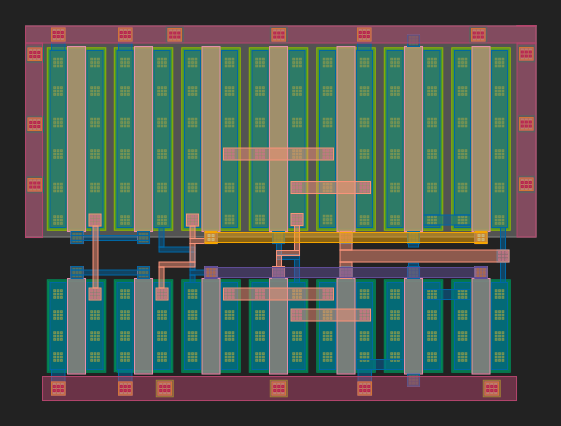

In [ ]:
library = gdstk.read_gds('gds/cp.gds')
top_cells = library.top_level()
top_cells[0].write_svg('images/cp.svg')
cairosvg.svg2png(url='images/cp.svg', write_to='images/cp.png', scale=1.0)
Image('images/cp.png')

# Complete PLL loop design and simulation

All the blocks simulated in the previous section are integrated together to form the complete PLL loop.

### Generating gds and `spice` netlists from `.mag` for complete PLL

In [ ]:
!cd 2.87GHz-MWG-SKY130/mag/ && cp */* .

In [ ]:
%%script magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc

load 2.87GHz-MWG-SKY130/mag/pll_full.mag

extract
ext2spice lvs
ext2spice cthresh 0
ext2spice

gds labels no
gds write gds/pll_full.gds


Magic 8.3 revision 464 - Compiled on Sat Mar  9 23:18:29 UTC 2024.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Scaled tech values by 2 / 1 to match internal grid scaling
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.471-0-g97d0844
Cell pll_full read from path 2.87GHz-MWG-SKY130/mag
Scaled magic input cell pll_full geometry by factor of 2
Cell ro_with_cbank read from path 2.87GHz-MWG-SKY130/mag
Scaled magic input cell ro_with_cbank geometry by factor of 2
Cell cbank_smol read from path 2.87GHz-MWG-SKY130/mag
Cell switch read from path 2.87GHz-MWG-SKY130/mag
Scaled magic input cell switch geometry by factor of 2
Cell ro_var_exten

freeMagic called with NULL argument.
Total of 2 warnings.


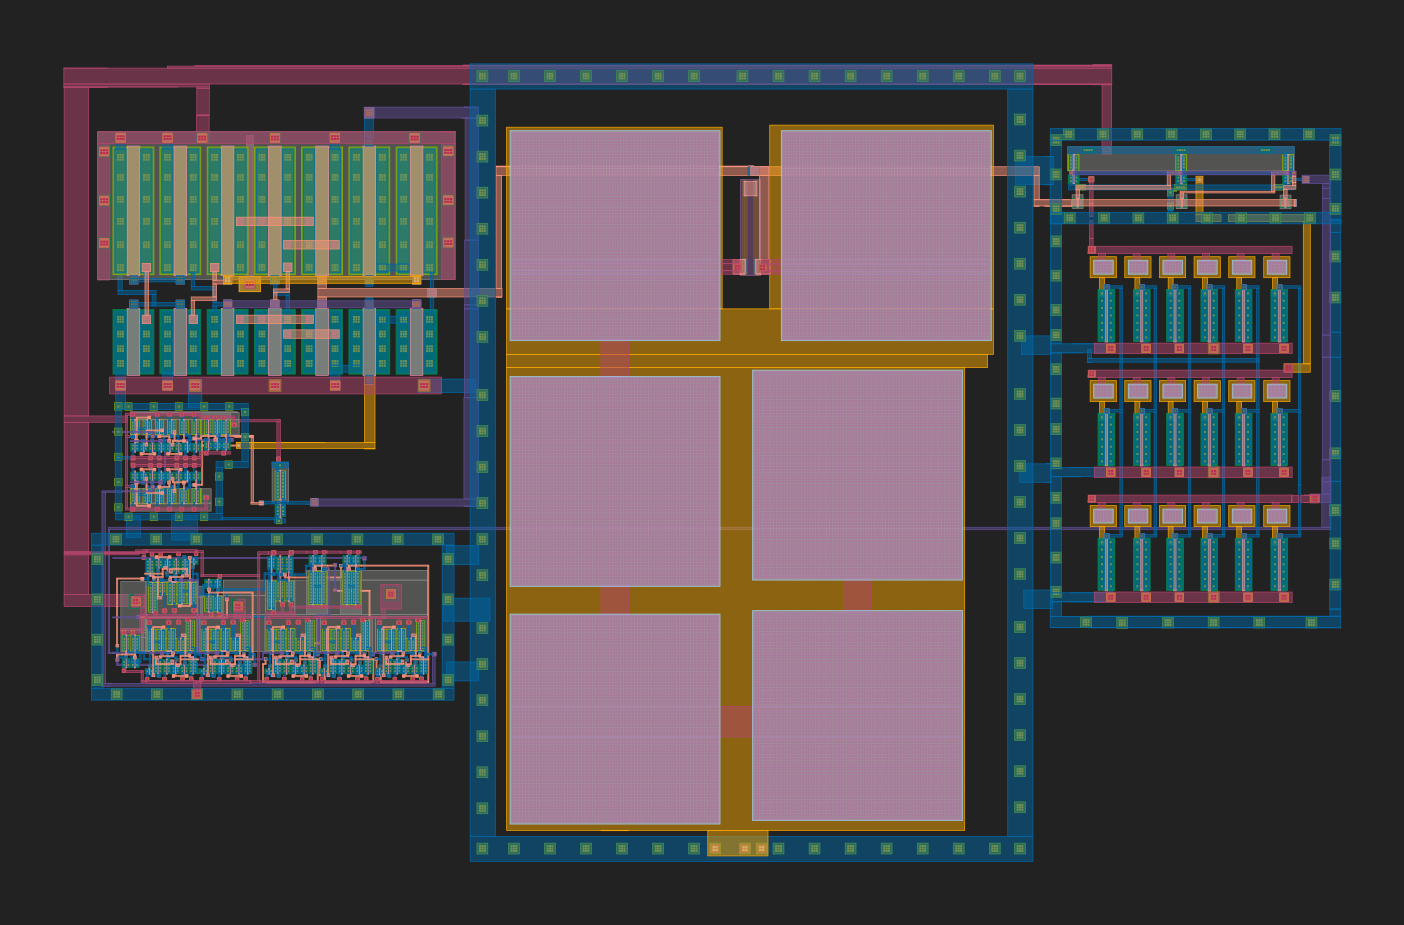

In [ ]:
library = gdstk.read_gds('gds/pll_full.gds')
top_cells = library.top_level()
top_cells[0].write_svg('images/pll_full.svg')
cairosvg.svg2png(url='images/pll_full.svg', write_to='images/pll_full.png', scale=0.7)
Image('images/pll_full.png')

### Simulating PLL

> Note: The following cell takes quite a lot of time to run (possibly even days....which is beyond the collab timeout limit). For a quick run to verify that the netlist runs and signals are as expected, change `.tran` time to desired value.

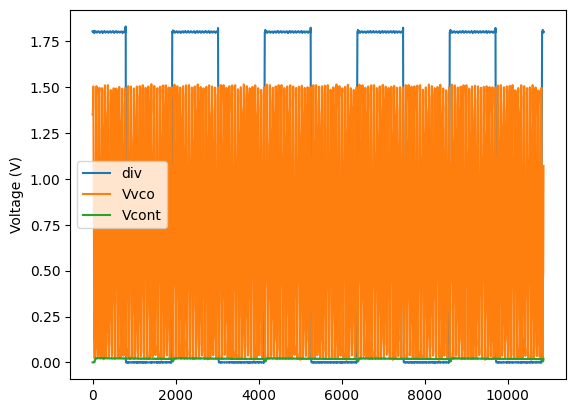

Frequency of div = 16.23705054626309 MHz
Frequency of VCO = 517.9050120775448 MHz


In [ ]:
!mv *.spice sim/

path = "sim/pll_full.spice"
signals = """vref ref gnd pulse 1.8 0 0ns 10ps 10ps 0.4ns 0.8ns
vmc mc2 gnd dc 0
va a gnd dc 0"""
sim = """.tran 0.1ns 300ns
.measure tran div TRIG v(div) VAL=0.9  RISE=1  TARG v(div) VAL=0.9  RISE=2
.measure tran VCO TRIG v(VCO) VAL=0.9  RISE=10  TARG v(VCO) VAL=0.9  RISE=11"""
control = "print v(div) v(VCO) v(cp_0/out)> pll_data.txt"
control = control+"\nquit"
mod_extracted_net(path, signals, sim, control)

!cd sim/ && ngspice pll_full_sim.spice > pll_out.txt
clear_output(wait=False)

plot_from_op(read_op_file("sim/pll_data.txt", ["div", "Vvco", "Vcont"]))

meas = read_meas_from_spice_out('sim/pll_out.txt')
print("Frequency of div = "+ str(1e-6*1/float(meas[0])) +" MHz")
print("Frequency of VCO = "+ str(1e-6*1/float(meas[1])) +" MHz")

In order to find the range of the PLL over which it successfully locks, it is necessary to simulate the PLL for the different configurations of the modulus control signal.

> Note: The following cell takes quite a lot of time to run and observe PLL locking (possibly even days....which is beyond the collab timeout limit)

In [ ]:
!mv *.spice sim/
path = "sim/pll_full.spice"
sim = """.tran 0.1ns 300ns
.measure tran div TRIG v(div) VAL=0.9  RISE=1  TARG v(div) VAL=0.9  RISE=2
.measure tran VCO TRIG v(VCO) VAL=0.9  RISE=10  TARG v(VCO) VAL=0.9  RISE=11"""

signals = """vref ref gnd pulse 1.8 0 0ns 10ps 10ps 0.4ns 0.8ns
vmc mc2 gnd dc 0
va a gnd dc 0"""
control = "print v(div) v(VCO) v(cp_0/out)> pll_data_0.txt"
control = control+"\nquit"
mod_extracted_net(path, signals, sim, control)
!cd sim/ && ngspice pll_full_sim.spice > pll_out_0.txt
clear_output(wait=False)

signals = """vref ref gnd pulse 1.8 0 0ns 10ps 10ps 0.4ns 0.8ns
vmc mc2 gnd dc 1.8
va a gnd dc 1.8"""
control = "print v(div) v(VCO) v(cp_0/out)> pll_data_1.txt"
control = control+"\nquit"
mod_extracted_net(path, signals, sim, control)
!cd sim/ && ngspice pll_full_sim.spice > pll_out_1.txt
clear_output(wait=False)


plot_from_op(read_op_file("sim/pll_data_0.txt", ["div", "Vvco", "Vcont"]))
meas = read_meas_from_spice_out('sim/pll_out_0.txt')
print("Frequency of div = "+ str(1e-6*1/float(meas[0])) +" MHz")
print("Frequency of VCO = "+ str(1e-6*1/float(meas[1])) +" MHz")

plot_from_op(read_op_file("sim/pll_data_1.txt", ["div", "Vvco", "Vcont"]))
meas = read_meas_from_spice_out('sim/pll_out_1.txt')
print("Frequency of div = "+ str(1e-6*1/float(meas[0])) +" MHz")
print("Frequency of VCO = "+ str(1e-6*1/float(meas[1])) +" MHz")

# References

1. M. I. Ibrahim, C. Foy, D. R. Englund and R. Han, "High-Scalability CMOS Quantum Magnetometer With Spin-State Excitation and Detection of Diamond Color Centers," in IEEE Journal of Solid-State Circuits, vol. 56, no. 3, pp. 1001-1014, March 2021.

1. D. Kim, M. I. Ibrahim, C. Foy, M. E. Trusheim, R. Han, and D. R. Englund, “A CMOS-Integrated Quantum Sensor Based on Nitrogen–Vacancy Centres,” Nature Electron., vol. 2, no. 7, pp. 284–289, Jul. 2019.

1. M. I. Ibrahim, C. Foy, D. R. Englund and R. Han, "29.2 A Scalable Quantum Magnetometer in 65nm CMOS with Vector-Field Detection Capability," 2019 IEEE International Solid- State Circuits Conference - (ISSCC), 2019, pp. 458-461.

1. M. I. Ibrahim, C. Foy, D. Kim, D. R. Englund and R. Han, "Room-Temperature Quantum Sensing in CMOS: On-Chip Detection of Electronic Spin States in Diamond Color Centers for Magnetometry," 2018 IEEE Symposium on VLSI Circuits, 2018, pp. 249-250.

1. A. S. Edakkadan, K. Saha, M. S. Baghini and A. Srivastava, "Design of 2.87 GHz Frequency Synthesizer with Programmable Sweep for Diamond Color Defect
based CMOS Quantum Sensing Applications," 2022 IEEE International Symposium on Circuits and Systems (ISCAS), Austin, TX, USA, 2022, pp. 3092-3096.

1. L. Kong and B. Razavi, "A 2.4 GHz 4 mW Integer-N Inductorless RF Synthesizer," in IEEE Journal of Solid-State Circuits, vol. 51, no. 3, pp. 626-635, March 2016.

1. S. Jia, S. Yan, Y. Wang and G. Zhang, "A Low-Power High-Speed 32/33 Prescaler Based on Novel Divide-by-4/5 Unit with Improved True Single-Phase Clock Logic," 2015 IEEE International Symposium on Circuits and Systems (ISCAS), 2015, pp. 890-893.

1. Jan M. Rabaey, Digital Integrated Circuits: A Design Perspective, Prentice-Hall, USA, 1996.

1. B. Razavi, Design of Analog CMOS Integrated Circuits, McGraw-Hill, Boston, 2001.

1. B. Razavi, RF Microelectronics, Prentice Hall, 1997.

1. T. Lin, C. Ti and Y. Liu, "Dynamic Current-Matching Charge Pump and Gated-Offset Linearization Technique for Delta-Sigma Fractional- $N$ PLLs," in IEEE Transactions on Circuits and Systems I: Regular Papers, vol. 56, no. 5, pp. 877-885, May 2009.

1. A. Srivastava et al., "Bio-WiTel: A Low-Power Integrated Wireless Telemetry System for Healthcare Applications in 401–406 MHz Band of MedRadio Spectrum," in IEEE Journal of Biomedical and Health Informatics, vol. 22, no. 2, pp. 483-494, March 2018.

1. L. Kong and B. Razavi, "19.5 A 2.4GHz RF Fractional-N Synthesizer with 0.25fREF BW," 2017 IEEE International Solid-State Circuits Conference (ISSCC), 2017, pp. 330-331.

1. L. Kong and B. Razavi, "A 2.4-GHz 6.4-mW Fractional-N Inductorless RF Synthesizer," in IEEE Journal of Solid-State Circuits, vol. 52, no. 8, pp. 2117-2127, Aug. 2017.